In [47]:
import numpy as np
import pandas as pd

In [ ]:
#pickle data frame
#float_data = np.array(data_frame)

In [160]:
aapl = pd.read_csv("AAPL_data.csv")
aapl["change"] = (aapl.close - aapl.open) / aapl.open * 100
aapl_data = np.array(aapl[["change", "volume"]])
aapl_data

float_data = np.array(aapl[["change", "volume"]])

In [49]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [161]:

# [ : val_slice : test_slice ]

val_slice = 800
test_slice = 1100


mean = float_data[:val_slice].mean(axis=0)
float_data -= mean
std = float_data[:val_slice].std(axis=0)
float_data /= std

float_data

array([[ 0.17278246,  2.65755038],
       [ 0.56388659,  1.80736799],
       [-1.83046386,  2.47259712],
       ..., 
       [-1.23529692,  0.16497982],
       [ 4.05224238,  0.03383934],
       [-1.64176399, -0.45152418]])

In [156]:
lookback = 5 # How many timesteps back the input data should go.
step = 1 # The period, in timesteps, at which you sample data. 
delay = 1 # How many timesteps in the future the target should be.
batch_size = 32 # Number big enough that it could be representatative of the whole 

train_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=val_slice,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)

val_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=(val_slice+1),
                        max_index=test_slice,
                        step=step,
                        batch_size=batch_size)

test_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=test_slice+1,
                        max_index=None,
                        step=step,
                        batch_size=batch_size)

val_steps = (test_slice - (val_slice+1) - lookback)
test_steps = (len(float_data) - (test_slice+1) - lookback)

In [162]:
print(val_steps, test_steps)
float_data.shape[-1] # number of variables

294 153


2

In [123]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [150]:
model = Sequential()
# Can replace GRU with RNN or LTSM for experimentation.
model.add(layers.GRU(16, input_shape=(None, float_data.shape[-1]),
                    recurrent_dropout = .5))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')


In [151]:
history = model.fit_generator(train_gen,
                            steps_per_epoch=16, # 
                            epochs=16, # passes through the training data
                            validation_data=val_gen,
                            validation_steps=val_steps,
                             verbose=1)

Epoch 1/16
16/16 [==============================] - 22s 1s/step - loss: 0.7373 - val_loss: 0.8910
Epoch 2/16
16/16 [==============================] - 7s 449ms/step - loss: 0.8040 - val_loss: 0.7814
Epoch 3/16
16/16 [==============================] - 8s 494ms/step - loss: 0.6422 - val_loss: 0.6626
Epoch 4/16
16/16 [==============================] - 7s 450ms/step - loss: 0.6322 - val_loss: 0.5865
Epoch 5/16
16/16 [==============================] - 7s 438ms/step - loss: 0.6317 - val_loss: 0.5039
Epoch 6/16
16/16 [==============================] - 8s 475ms/step - loss: 0.6181 - val_loss: 0.4621
Epoch 7/16
16/16 [==============================] - 7s 451ms/step - loss: 0.5189 - val_loss: 0.4201
Epoch 8/16
16/16 [==============================] - 7s 462ms/step - loss: 0.5701 - val_loss: 0.4131
Epoch 9/16
16/16 [==============================] - 7s 444ms/step - loss: 0.5973 - val_loss: 0.4031
Epoch 10/16
16/16 [==============================] - 7s 432ms/step - loss: 0.5303 - val_loss: 0.3923
E

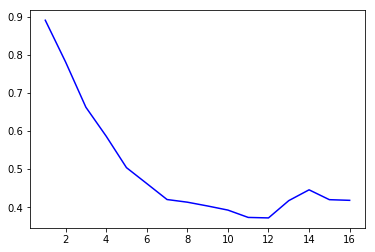

In [153]:
val_loss = history.history['val_loss']
epochs = range(1, len(val_loss) + 1)

import matplotlib.pyplot as plt
plt.plot(epochs, val_loss, 'b', label='Validation loss')